## 1. Importing libraries
* `pandas` - reads and stores the data
* `matplotlib` and `seaborn` - displays the data
* `sklearn` - trains the model and classifies the data
* `numpy` - performs math operations

In [169]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from random import sample

from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


## 2. Loading the data

In [170]:
url = 'mushrooms.csv'
dataset = pd.read_csv(url, header=0)
dataset.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


Here, we're just collecting some information about the structure of the data.


In [171]:
# shape
print(dataset.shape)

# head
print(dataset.head(20))

# descriptions
print(dataset.describe())

(8124, 23)
   class cap-shape cap-surface cap-color bruises odor gill-attachment  \
0      p         x           s         n       t    p               f   
1      e         x           s         y       t    a               f   
2      e         b           s         w       t    l               f   
3      p         x           y         w       t    p               f   
4      e         x           s         g       f    n               f   
5      e         x           y         y       t    a               f   
6      e         b           s         w       t    a               f   
7      e         b           y         w       t    l               f   
8      p         x           y         w       t    p               f   
9      e         b           s         y       t    a               f   
10     e         x           y         y       t    l               f   
11     e         x           y         y       t    a               f   
12     e         b           s         y

We can use the class distribution to see that the data is for the most part, pretty balanced. There's just a little more of the dataset that is edible than poisonous.

In [172]:
# Class distribution 
grouped_dataset = dataset.groupby('class').size()
print(grouped_dataset)
num_edible = grouped_dataset['e']
num_poisonous = grouped_dataset['p']
print(f"% poisonous: {num_poisonous / len(dataset) * 100: .2f}%")

class
e    4208
p    3916
dtype: int64
% poisonous:  48.20%


## 3. Cleaning the data
Since the attributes of the mushrooms are stored as characters, we can convert them to numbers so that it will be easier to classify.

sklearn's `LabelEncoder` can be used to convert the categorical data into numeric data.

In [173]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
for col in dataset.columns:
  dataset[col] = encoder.fit_transform(dataset[col])

dataset.head()

# Now, we're just working with numbers. Much better!

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,5,2,4,1,6,1,0,1,4,...,2,7,7,0,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1


Checking for null values here, but since there are none, we won't have to worry about replacing them. Thanks, ACM!

In [174]:
dataset.apply(lambda x: sum(x.isnull()), axis=0)

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

## 4. Exploratory analysis of the data
Now, it's time to start looking for any correlation between the different characteristics that a mushroom has.

First, we can use a correlation heatmap and start to see some relationships between certain pairs of attributes (Plus, it looks cool). For example, it looks like *gill-color* has a large correlation with its *class*. 

<AxesSubplot:>

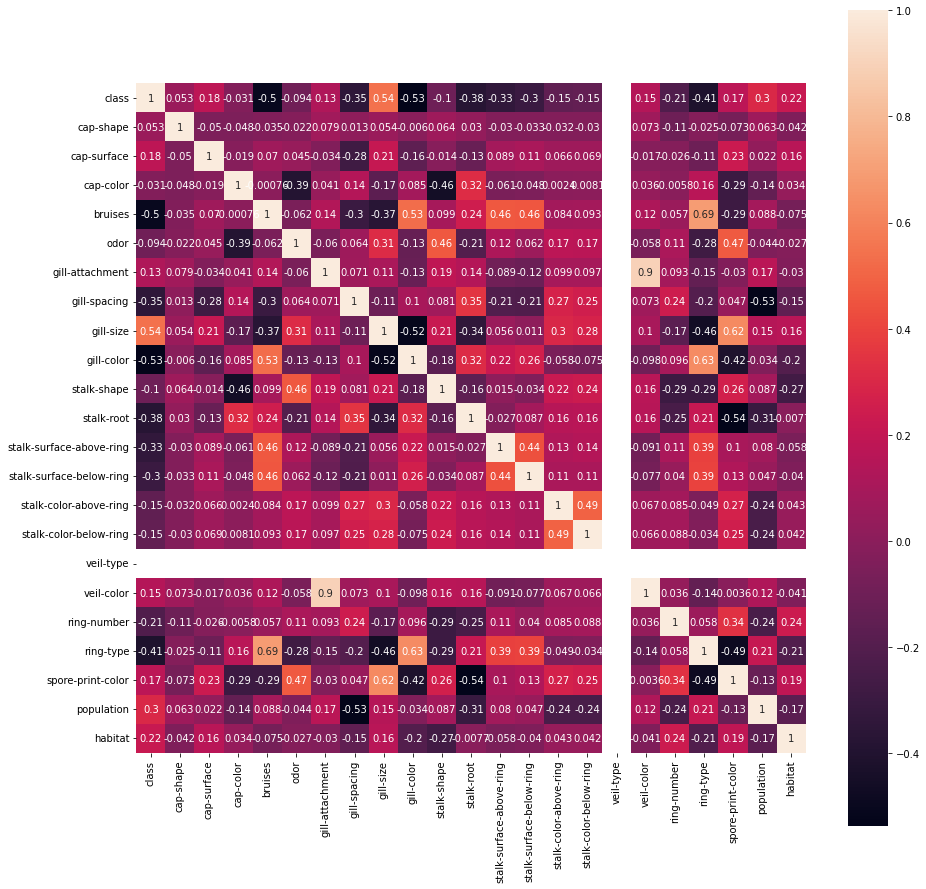

In [175]:
# Correlation heatmap
correlation = dataset.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(correlation, vmax=1, square=True, annot=True)

## 5. Splitting the data
Now we split the data into the training, testing, and (optionally) validation sets. I used the `split()` method from `numpy` to do this. Another way to do this is by using the `train_test_split()` from `sklearn`, but I wanted to include a validation set as well to see how well the model will perform.
* Training dataset: random sample of ~60% of the dataset
* Testing dataset: random sample of ~20% of the dataset
* Validation dataset: random sample of ~20% of the dataset

In [176]:
# Randomly splitting the data into testing, training, and validation sets
train, test, validate = np.split(dataset.sample(frac=1), [int(.6*len(dataset)), int(.8*len(dataset))])
print(train.shape, test.shape, validate.shape)

# Separating target and predictors
y_train = train['class']
x_train = train.drop(['class'], axis=1)
y_test = test['class']
x_test = test.drop(['class'], axis=1)
y_validate = validate['class']
x_validate = validate.drop(['class'], axis=1)

(4874, 23) (1625, 23) (1625, 23)


sklearn's `RandomForestClassifer` can be used to find the importance of the different attributes, so we can gather more information about how a mushroom's attributes may affect their class.

Features sorted by their score: 
[(0.1748, 'odor'), (0.1173, 'gill-size'), (0.1036, 'spore-print-color'), (0.0985, 'gill-color'), (0.0829, 'ring-type'), (0.0698, 'stalk-root'), (0.0565, 'population'), (0.0543, 'bruises'), (0.0507, 'stalk-surface-above-ring'), (0.0483, 'gill-spacing'), (0.0296, 'stalk-surface-below-ring'), (0.0226, 'habitat'), (0.0189, 'stalk-color-below-ring'), (0.0164, 'stalk-shape'), (0.0139, 'cap-surface'), (0.0117, 'ring-number'), (0.0114, 'cap-color'), (0.0076, 'stalk-color-above-ring'), (0.0044, 'cap-shape'), (0.0043, 'veil-color'), (0.0024, 'gill-attachment'), (0.0, 'veil-type')]


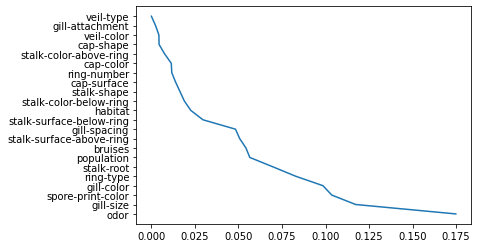

In [177]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
print("Features sorted by their score: ")
importances = sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), x_train), reverse=True)
print(importances)
plt.plot(*zip(*importances))

## 6. Modelling
I evaluted each of the models using 10-fold cross-validation. Models evaluated: *Logistic Regression (LR), Random Forest Classifier (RF), Linear Discriminant Analysis (LDA), K-Neighbors Classifier (KNN), Decision Tree Classifier (CART), Two Class Bayes (NB), and Support Vector Machine (SVM)*.

I then compared each of their metrics, such as accuracy, precision, recall, and standard deviation, in order to determine which model performs the best.

  Model  Accuracy  Precision    recall        F1  cv_precision    cv_std
1    RF  1.000000   1.000000  1.000000  1.000000      1.000000  0.000000
4  CART  1.000000   1.000000  1.000000  1.000000      0.999589  0.001232
6   SVM  1.000000   1.000000  1.000000  1.000000      0.999795  0.000616
3   KNN  0.996308   0.994778  0.997382  0.996078      0.996308  0.002561
2   LDA  0.936000   0.950820  0.910995  0.930481      0.948093  0.006545
0    LR  0.941538   0.947791  0.926702  0.937128      0.950964  0.006897
5    NB  0.915692   0.909804  0.910995  0.910399      0.921826  0.008858


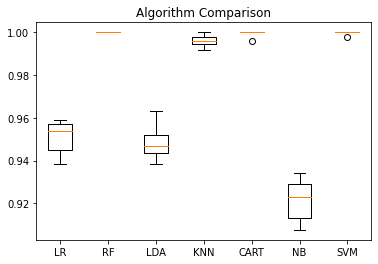

In [178]:
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('RF', RandomForestClassifier()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto', probability=True)))

results = []
names = []

accuracies = []
precisions = []
recalls = []
f1s = []
cv_precisions = []
cv_stds = []

# Evaluate each model in turn
for name, model in models:
    model_fit = model.fit(x_train, y_train)
    model_fit.score(x_train, y_train)
    predicted = pd.DataFrame(model_fit.predict(x_test))
    probs = pd.DataFrame(model_fit.predict_proba(x_test))

    # Storing metrics
    accuracy = metrics.accuracy_score(y_test, predicted)
    roc_auc = metrics.roc_auc_score(y_test, probs[1])
    confus_matrix = metrics.confusion_matrix(y_test, predicted)
    class_report = metrics.classification_report(y_test, predicted)
    precision = metrics.precision_score(y_test, predicted, pos_label=1)
    recall = metrics.recall_score(y_test, predicted, pos_label=1)
    f1 = metrics.f1_score(y_test, predicted, pos_label=1)

    # Evaluating the models using 10-fold cross-validation
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_scores = cross_val_score(model, x_train, y_train, cv=kfold, scoring='accuracy')
    cv_mean = np.mean(cv_scores)
    cv_std = cv_scores.std()
    results.append(cv_scores)
    names.append(name)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    cv_precisions.append(cv_mean)
    cv_stds.append(cv_std)


models_df = pd.DataFrame({
    'Model' : names,
    'Accuracy' : accuracies,
    'Precision' : precisions,
    'recall' : recalls,
    'F1' : f1s,
    'cv_precision' : cv_precisions,
    'cv_std' : cv_stds
})

print(models_df.sort_values(by='Precision', ascending=False))
# Compare algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()


By the looks of it, the **Random Forest Classifier (RF)** model performs consistently with the highest accuracy, precision, and recall metrics. The **Decision Tree Classifier (CART)** and **Support Vector Machine (SVM)** models also achieve an accuracy of 100% *most* of the time, but it is not as consistent as the RF model. You can see for yourself by running the code cell above a few times.

Since the RF model performs so well, one concern could be if the data has been overfitted. However, since each model is evaluated with 10-fold cross validation on a test dataset, this is much less likely.

Now we can use the Random Forest Classifier model to make and evaluate predictions on the validation dataset.

In [179]:
# Making predictions on the validation dataset
model = RandomForestClassifier()
model.fit(x_train, y_train)
predictions = model.predict(x_validate)

# Evaluating the predictions
print(metrics.accuracy_score(y_validate, predictions))
print(metrics.confusion_matrix(y_validate, predictions))
print(metrics.classification_report(y_validate, predictions))

1.0
[[846   0]
 [  0 779]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       846
           1       1.00      1.00      1.00       779

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



## 7. Exporting the model
The model can now be exported after re-training the model on the entire dataset.

I use `pickle` here to export the model into a Python Pickle File (.pkl).

In [180]:
y = dataset['class']
x = dataset.drop(['class'], axis=1)

# Re-train model
rf_model = rf.fit(x, y)

# Export the model
import pickle as cPickle
with open('mushroom_classifier.pkl', 'wb') as fid:
  cPickle.dump(rf_model, fid)


You made it to the end! Enjoy this complimentary meme:

![mushroom meme](meme.jpg)

Will our models ever progress to the point of being able to identify the *Dumb Idiot's False Brown Cap* mushroom? Only time will tell.